In [1]:
import polars as pl
import tqdm
import numpy as np
import seaborn as sns

import sys
sys.path.append('/home/ubuntu/RecSysChallenge2024/src')

from fastauc.fastauc.fast_auc import CppAuc

In [2]:
predictions_df = None

paths = {
    'gandalf': '/mnt/ebs_volume/stacking/stacking/pred_val_large/pred_val_gandalf_new_trial_130.parquet',
    'mlp': '/mnt/ebs_volume/stacking/stacking/pred_val_large/pred_val_mlp_new_trial_208.parquet',
    'wide_deep': '/mnt/ebs_volume/stacking/stacking/pred_val_large/pred_val_wide_deep_new_trial_72.parquet',
    'deep_cross': '/mnt/ebs_volume/stacking/stacking/pred_val_large/pred_val_deep_cross_new_trial_67.parquet',
    'catboost': '/mnt/ebs_volume/stacking/stacking/pred_val_large/pred_val_catboost_new_noK.parquet',
    # 'ranker': '/mnt/ebs_volume/stacking/stacking/pred_val_large',
}
for model_name, path in paths.items():
    
    model_preds = pl.read_parquet(path) \
        .rename({'prediction': f'{model_name}_prediction'}) \
        .with_columns(
            pl.col(f'{model_name}_prediction').min().over('impression_id').alias('min_pred_impression'),
            pl.col(f'{model_name}_prediction').max().over('impression_id').alias('max_pred_impression'),
        ).with_columns(
            (
                (pl.col(f'{model_name}_prediction') - pl.col('min_pred_impression')) /
                (pl.col('max_pred_impression') - pl.col('min_pred_impression'))
            ).alias(f'{model_name}_prediction')
        ).select(['impression_id', 'article', 'target', f'{model_name}_prediction'])
        
    evaluation_ds_grouped = model_preds.group_by(
            'impression_id').agg(pl.col('target'), pl.col(f'{model_name}_prediction'))
    
    cpp_auc = CppAuc()
    auc = np.mean(
        [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
            for y_t, y_s in zip(evaluation_ds_grouped['target'].to_list(), 
                                evaluation_ds_grouped[f'{model_name}_prediction'].to_list())]
    )
    print(f'AUC of {model_name}: {auc}')
    
    if predictions_df is None:
        predictions_df = model_preds
    else:
        predictions_df = predictions_df.join(model_preds.drop('target'), 
                                             on=['impression_id', 'article'], how='left')
predictions_df.head()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0xf9d16428b8b0>>
Traceback (most recent call last):
  File "/home/ubuntu/RecSysChallenge2024/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


<Axes: >

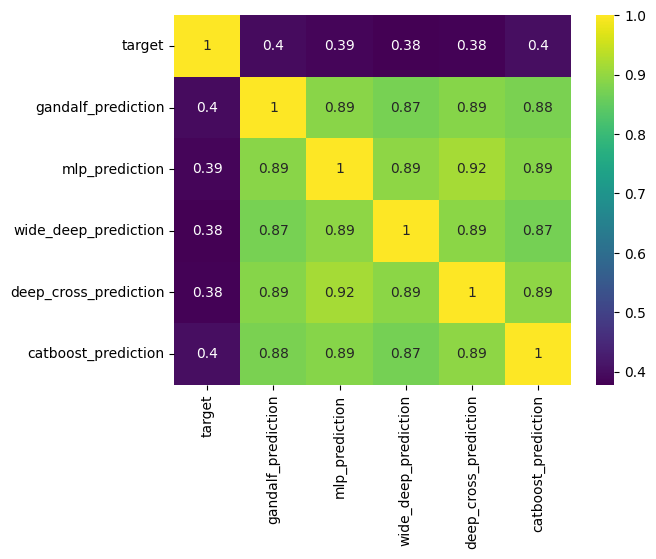

In [3]:
correlations = predictions_df.drop(['impression_id', 'article']).to_pandas().corr()

sns.heatmap(correlations, cmap='viridis', annot=True)

In [5]:
weight_mean_predictions_df = predictions_df.with_columns(
    (
        0.2 * pl.col('gandalf_prediction') + 
        0.2 * pl.col('mlp_prediction') + 
        0.2 * pl.col('wide_deep_prediction') + 
        0.2 * pl.col('catboost_prediction') + 
        0.2 * pl.col('deep_cross_prediction')
    ).alias('weight_mean_pred'),
)

evaluation_ds_grouped = weight_mean_predictions_df.group_by(
    'impression_id').agg(pl.col('target'), pl.col('weight_mean_pred'))

cpp_auc = CppAuc()
auc = np.mean(
    [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
        for y_t, y_s in zip(evaluation_ds_grouped['target'].to_list(), 
                            evaluation_ds_grouped['weight_mean_pred'].to_list())]
)
auc

0.8238129848736995

In [6]:
weight_mean_predictions_df = predictions_df.with_columns(
    (
        0.2 * pl.col('gandalf_prediction') + 
        0.2 * pl.col('mlp_prediction') +
        0.1 * pl.col('wide_deep_prediction') + 
        0.3 * pl.col('catboost_prediction') + 
        0.2 * pl.col('deep_cross_prediction')
    ).alias('weight_mean_pred'),
)

evaluation_ds_grouped = weight_mean_predictions_df.group_by(
    'impression_id').agg(pl.col('target'), pl.col('weight_mean_pred'))

cpp_auc = CppAuc()
auc = np.mean(
    [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
        for y_t, y_s in zip(evaluation_ds_grouped['target'].to_list(), 
                            evaluation_ds_grouped['weight_mean_pred'].to_list())]
)
auc

0.8242044130132983

In [10]:
predictions_df = None

paths = {
    'gandalf': '/mnt/ebs_volume/stacking/stacking/pred_test/pred_test_gandalf_new_trial_130.parquet',
    'mlp': '/mnt/ebs_volume/stacking/stacking/pred_test/pred_test_mlp_new_trial_208.parquet',
    'wide_deep': '/mnt/ebs_volume/stacking/stacking/pred_test/pred_test_wide_deep_new_trial_72.parquet',
    'deep_cross': '/mnt/ebs_volume/stacking/stacking/pred_test/pred_test_deep_cross_new_trial_67.parquet',
    'catboost': '/mnt/ebs_volume/stacking/stacking/pred_test/pred_test_catboost_new_noK.parquet',
    # 'ranker': '/mnt/ebs_volume/stacking/stacking/pred_test',
}
for model_name, path in paths.items():
    
    model_preds = pl.read_parquet(path) \
        .rename({'prediction': f'{model_name}_prediction'}) \
        .with_columns(
            pl.col(f'{model_name}_prediction').min().over('impression_id').alias('min_pred_impression'),
            pl.col(f'{model_name}_prediction').max().over('impression_id').alias('max_pred_impression'),
        ).with_columns(
            (
                (pl.col(f'{model_name}_prediction') - pl.col('min_pred_impression')) /
                (pl.col('max_pred_impression') - pl.col('min_pred_impression'))
            ).alias(f'{model_name}_prediction')
        ).select(['impression_id', 'article', 'user_id', f'{model_name}_prediction'])
    
    if predictions_df is None:
        predictions_df = model_preds
    else:
        predictions_df = predictions_df.join(model_preds, on=['impression_id', 'article', 'user_id'], how='left')
predictions_df.head()

impression_id,article,user_id,gandalf_prediction,mlp_prediction,wide_deep_prediction,deep_cross_prediction,catboost_prediction
u32,i32,u32,f32,f32,f32,f32,f64
6880427,9756075,1274780,0.077322,0.095132,0.232588,0.223017,0.327733
6869675,9789473,1238642,0.63036,0.804009,0.696939,0.806108,0.656307
6908287,9791205,1351925,0.71094,0.426831,0.63878,0.683612,0.100522
6871530,9791525,1245302,0.035608,0.004494,0.002756,0.034157,0.025607
6765726,9791515,1183377,0.648761,0.752831,0.966181,0.860698,0.624713


In [11]:
weight_mean_predictions_df = predictions_df.with_columns(
    (
        0.2 * pl.col('gandalf_prediction') + 
        0.2 * pl.col('mlp_prediction') + 
        0.2 * pl.col('wide_deep_prediction') + 
        0.2 * pl.col('catboost_prediction') + 
        0.2 * pl.col('deep_cross_prediction')
    ).alias('prediction'),
).select(['impression_id', 'article', 'user_id', 'prediction'])

weight_mean_predictions_df.write_parquet('/home/ubuntu/experiments/weighted_mean_equal_neurals_catboost/predictions.parquet')

In [12]:
weight_mean_predictions_df = predictions_df.with_columns(
    (
        0.2 * pl.col('gandalf_prediction') + 
        0.2 * pl.col('mlp_prediction') + 
        0.1 * pl.col('wide_deep_prediction') + 
        0.3 * pl.col('catboost_prediction') + 
        0.2 * pl.col('deep_cross_prediction')
    ).alias('prediction'),
).select(['impression_id', 'article', 'user_id', 'prediction'])

weight_mean_predictions_df.write_parquet('/home/ubuntu/experiments/weighted_mean_neurals_catboost/predictions.parquet')